In [1]:
import matplotlib.pyplot as plt
import numpy as np
from argparse import Namespace

import torch
import torch.nn.functional as F
import pytorch3d 
import pytorch3d.transforms as T3
from pytorch3d.structures import Pointclouds
import pytorch_lightning as pl

from src.config import get_parser
from src.renderer import Renderer
from src.util import make_faces

In [2]:
config = get_parser().parse_args(args=[])
config.viewpoint_distance = 1.25
print(config)
device = torch.device("cuda")
renderer = Renderer(config)
renderer = renderer.to(device)
renderer

Namespace(D_act_name='Swish', D_filters=[3, 32, 64], D_num_outcomes=32, D_use_adaptive_reparam=True, D_use_spectral_norm=False, Dsteps=3, G_noise_amp=0.003, Gsteps=3, alpha=10, backbone='vgg11', beta1=0.5, blueprint='./data/blueprint127.npz', dlatent_size=128, gamma=0.1, in_channel=3, ker_size=3, lambda_grad=0.1, lights_location=[0.0, -1.0, 3.0], lr_d=0.0005, lr_g=0.0005, manualSeed=None, max_size=250, min_nfc=32, min_size=25, nc_im=3, nc_z=3, netD='', netG='', nfc=32, niter=2000, noise_amp=0.1, not_cuda=0, num_layer=5, out='Output', out_channel=32, padd_size=1, raster_image_size=512, raster_points_per_pixel=4, raster_radius=0.006, scale_factor=0.75, stride=1, viewpoint_azimuth=0.0, viewpoint_distance=1.25, viewpoint_elevation=0.0)


Renderer(
  (renderer): ShadingPointsRenderer(
    (rasterizer): PointsRasterizer(
      (cameras): FoVPerspectiveCameras()
    )
    (compositor): ShadingCompositor(
      (lights): PointLights()
      (materials): Materials()
      (cameras): FoVPerspectiveCameras()
    )
  )
)

In [3]:
print(config.blueprint)
blueprint =  np.load(config.blueprint)
print(blueprint['points'].shape, blueprint['normals'].shape)
points = torch.tensor(blueprint['points'])
normals = torch.tensor(blueprint['normals'])
print(points.shape, normals.shape)

./data/blueprint127.npz
(1, 3, 256, 256) (1, 3, 256, 256)
torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])


mean tensor([-0.3746, -0.0022,  0.3160], device='cuda:0')
torch.Size([16384, 3]) torch.Size([16384, 3])


(-0.5, 511.5, 511.5, -0.5)

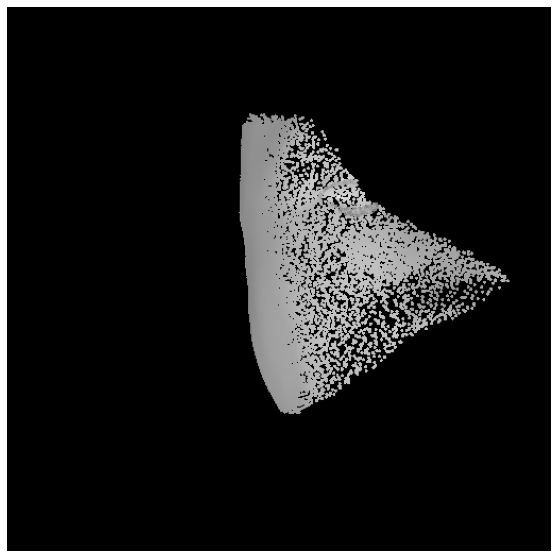

In [9]:
torch.set_printoptions(sci_mode=False, precision=4)
s1, d1 = 0, 128 
s2, d2 = 0, 128

pt_points =  points[0, :, s1:s1+d1, s2:s2+d2].reshape(3, -1).t().to(device)
pt_normals =  normals[0, :, s1:s1+d1, s2:s2+d2].reshape(3, -1).t().to(device)

pt_mean = pt_points.mean(dim=0)
print('mean', pt_mean)

print(pt_points.shape, pt_normals.shape)

T = T3.Translate(-pt_mean[None]).to(device)

pt_points = T.transform_points(pt_points)
pt_normals = T.transform_normals(pt_normals)

rgb = torch.ones((pt_points.size(0), 4), device=device) - 0.3

point_cloud = Pointclouds(points=[pt_points], 
                          normals=[pt_normals],
                          features=[rgb])

images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off")

In [10]:
pt_mean

tensor([-0.3746, -0.0022,  0.3160], device='cuda:0')

In [11]:
torch.cos(pt_mean)

tensor([0.9307, 1.0000, 0.9505], device='cuda:0')

In [12]:
T3.axis_angle_to_matrix(torch.cos(pt_mean))

tensor([[ 0.2486, -0.2013,  0.9475],
        [ 0.9360,  0.3015, -0.1816],
        [-0.2491,  0.9320,  0.2634]], device='cuda:0')

mean tensor([-0.3746, -0.0022,  0.3160], device='cuda:0')
torch.Size([16384, 3]) torch.Size([16384, 3])


(-0.5, 511.5, 511.5, -0.5)

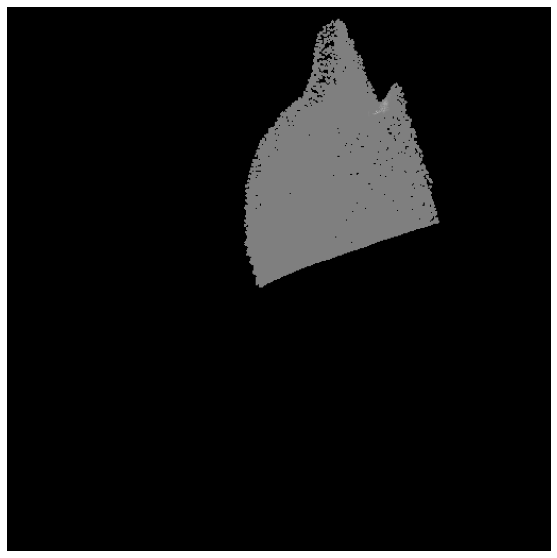

In [21]:
torch.set_printoptions(sci_mode=False, precision=4)
s1, d1 = 0, 128 
s2, d2 = 0, 128

pt_points =  points[0, :, s1:s1+d1, s2:s2+d2].reshape(3, -1).t().to(device)
pt_normals =  normals[0, :, s1:s1+d1, s2:s2+d2].reshape(3, -1).t().to(device)

pt_mean = pt_points.mean(dim=0)
print('mean', pt_mean)

print(pt_points.shape, pt_normals.shape)

T = T3.Translate(-pt_mean[None]).to(device)
R = T3.Rotate(T3.axis_angle_to_matrix(torch.cos(pt_mean))).to(device)
TR = T3.Transform3d().compose(R, T).to(device)

pt_points = TR.transform_points(pt_points)
pt_normals = TR.transform_normals(pt_normals)

rgb = torch.ones((pt_points.size(0), 4), device=device) - 0.3

point_cloud = Pointclouds(points=[pt_points], 
                          normals=[pt_normals],
                          features=[rgb])

images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off")

In [13]:
T3.Rotate(T3.axis_angle_to_matrix(torch.cos(pt_mean)))